<a href="https://colab.research.google.com/github/rujhannajib/mlbNittanyAI-rujhan/blob/main/Image_Classification_using_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Project: Fashion MNIST classification with Convolutional Neural Network

- Dataset: Fashion MNIST (Imported from pytorch library)
- Inspiration: https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy
- Improvement: Add third layer, use Gap instead of maxpool

By:
- Name: Muhammad Rujhan Najib Bin Fauzi Najib
- PSU ID: 950118053


In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
warnings.filterwarnings('ignore')

In [2]:
# use GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading Data

In [3]:
# load data using FashionMNIST from torchvision module
# transform the data from PIL/numpy array to tensor format
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:07<00:00, 3715379.66it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 199559.41it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 696750.51it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6149893.76it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# using loader to train and test model in batches, everytime we load data, we will get 100 images at once
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

In [5]:
# function to map label to outfit
def output_label(label):
  output_mapping = {
      0: "T-shirt/Top",
      1: "Trouser",
      2: "Pullover",
      3: "Dress",
      4: "Coat",
      5: "Sandal",
      6: "Shirt",
      7: "Sneaker",
      8: "Bag",
      9: "Ankle Boot"
  }
  input = (label.item() if type(label) == torch.Tensor else label)
  return output_mapping[input]


In [6]:
# Playing with some data
a = next(iter(train_loader))
len(a[1])

100

In [7]:
len(train_set)

60000

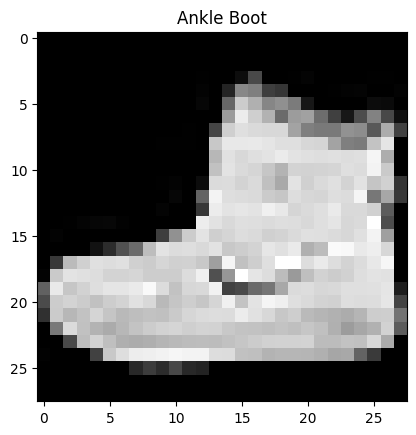

In [8]:
# Display image and its label
image, label = next(iter(train_loader))
plt.imshow(image[0].squeeze(), cmap='gray')
plt.title(output_label(label[0]))
plt.show()

In [9]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(images.shape, labels.shape)
print(type(images),type(labels))

torch.Size([10, 1, 28, 28]) torch.Size([10])
<class 'torch.Tensor'> <class 'torch.Tensor'>


labels: Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

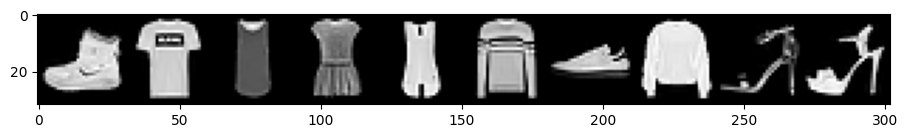

In [10]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(11,11))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels: ', end='')
for label in labels:
  print(output_label(label), end=', ')

## Building Convolutional Neural Network

In [11]:
# defining custom neural networks in pytorch
class FashionCNN(torch.nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()

    self.layer1 = torch.nn.Sequential(
        # in channel = 1 if using grayscale image
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
        )

    self.layer2 = torch.nn.Sequential(
        # dimension becomes smaller when padding is not specified
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )

    self.layer3 = torch.nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1))  # GAP instead of MaxPool, lower risk of overfitting
        )


    # output is flattened and passed through fully connected layer for classification
    self.fc1 = nn.Linear(in_features=128*1*1, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = out.view(out.size(0), -1) # flattened
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)

    return out

## Optimization

In [12]:
# optimization
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss() # for multi-class classification
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AdaptiveAvgPool2d(output_size=(1, 1))
 

# Training a network and testing it on test dataset

In [14]:
num_epochs = 10
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    # transferring image and label to GPU if available
    images, labels = images.to(device), labels.to(device)

    train  = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    # Forward pass
    outputs = model(train)
    loss = error(outputs, labels)

    # Initializing a gradient as 0 so there is no mixing of gradient among the batches
    optimizer.zero_grad()

    # backward pass to compute the gradient
    loss.backward()

    # update the weights
    optimizer.step()

    count += 1

    # Testing the model

    if not (count % 50):
      total = 0
      correct = 0

      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)

        test = Variable(images.view(100, 1, 28, 28))

        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()

        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    # print every 500 iteration
    if not (count % 500):
      print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.3341251015663147, Accuracy: 87.75%
Iteration: 1000, Loss: 0.4451950192451477, Accuracy: 89.36000061035156%
Iteration: 1500, Loss: 0.1869550496339798, Accuracy: 89.58999633789062%
Iteration: 2000, Loss: 0.23984557390213013, Accuracy: 89.62999725341797%
Iteration: 2500, Loss: 0.16789652407169342, Accuracy: 90.0999984741211%
Iteration: 3000, Loss: 0.15096937119960785, Accuracy: 89.9000015258789%
Iteration: 3500, Loss: 0.19159358739852905, Accuracy: 90.75%
Iteration: 4000, Loss: 0.1985645741224289, Accuracy: 90.1500015258789%
Iteration: 4500, Loss: 0.03140256553888321, Accuracy: 90.33999633789062%
Iteration: 5000, Loss: 0.1284475475549698, Accuracy: 89.88999938964844%
Iteration: 5500, Loss: 0.056215833872556686, Accuracy: 90.93999481201172%
Iteration: 6000, Loss: 0.054432883858680725, Accuracy: 89.93000030517578%


# Visualizing the loss and accuracy with iterations

In [15]:
print(type(iteration_list[0]))  # Check the type of iteration_list
print(type(loss_list[0]))

<class 'int'>
<class 'torch.Tensor'>


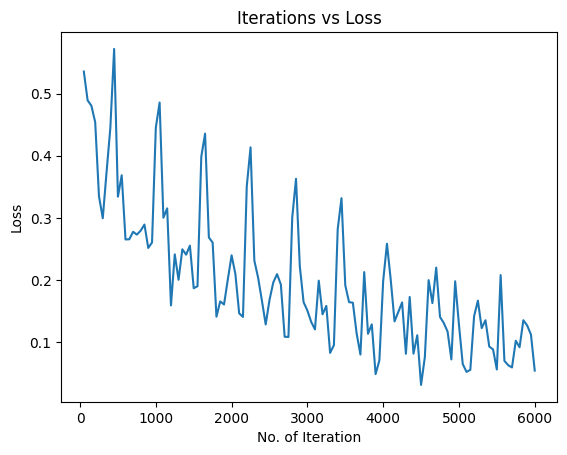

In [16]:
plt.plot(iteration_list, [loss.cpu().detach().numpy() for loss in loss_list])
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

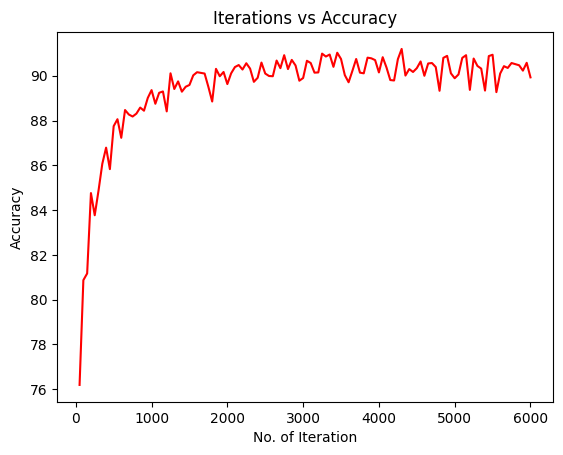

In [17]:
plt.plot(iteration_list, [acc.cpu().detach().numpy() for acc in accuracy_list], color="red")
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

# Looking the accuracy in each class of FashionMNIST data

In [18]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad(): # disable gradient evaluation
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    test = Variable(images)
    outputs = model(test)
    predicted = torch.max(outputs, 1)[1]
    c = (predicted == labels).squeeze()
    # print(c[0].item())

    for i in range(100):
      label = labels[i]
      class_correct[label] += c[i].item()
      total_correct[label] += 1

print(class_correct)
print(total_correct)
for i in range(10):
  print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))


[906.0, 982.0, 873.0, 942.0, 836.0, 970.0, 567.0, 963.0, 986.0, 966.0]
[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
Accuracy of T-shirt/Top: 90.60%
Accuracy of Trouser: 98.20%
Accuracy of Pullover: 87.30%
Accuracy of Dress: 94.20%
Accuracy of Coat: 83.60%
Accuracy of Sandal: 97.00%
Accuracy of Shirt: 56.70%
Accuracy of Sneaker: 96.30%
Accuracy of Bag: 98.60%
Accuracy of Ankle Boot: 96.60%


## Printing the confusion matrix

In [19]:
from itertools import chain
predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))
# predictions_l

In [20]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN: \n%s\n" % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN: 
              precision    recall  f1-score   support

           0       0.83      0.84      0.84    120000
           1       0.98      0.98      0.98    120000
           2       0.84      0.86      0.85    120000
           3       0.90      0.89      0.89    120000
           4       0.82      0.84      0.83    120000
           5       0.98      0.97      0.97    120000
           6       0.72      0.68      0.70    120000
           7       0.95      0.95      0.95    120000
           8       0.97      0.98      0.97    120000
           9       0.95      0.96      0.96    120000

    accuracy                           0.90   1200000
   macro avg       0.89      0.90      0.89   1200000
weighted avg       0.89      0.90      0.89   1200000


